In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Function
# 分批次训练，一批 64 个
BATCH_SIZE = 64
# 所有样本训练 3 次
EPOCHS = 100
# 学习率设置为 0.0006
LEARN_RATE = 2e-3

# 若当前 Pytorch 版本以及电脑支持GPU，则使用 GPU 训练，否则使用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
 
# 训练集数据加载
train_data = torchvision.datasets.MNIST(
    download=True,
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor()
)
# 构建训练集的数据装载器，一次迭代有 BATCH_SIZE 张图片
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
 
# 测试集数据加载
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
    transform=torchvision.transforms.ToTensor()
)
# 构建测试集的数据加载器，一次迭代 1 张图片，我们一张一张的测试
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle = True)
INPUT_SIZE = 784
HIDE_SIZE_I = 256
HIDE_SIZE_O = 64

In [4]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # 隐藏层 1，使用 sigmoid 激活函数
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDE_SIZE_I),
            nn.Sigmoid()
		)
        # 隐藏层 2，使用 sigmoid 激活函数
        self.layer2 = nn.Sequential(
            nn.Linear(HIDE_SIZE_I,HIDE_SIZE_O),
            nn.Sigmoid()
        )
        # 输出层
        self.layer_out = nn.Linear(HIDE_SIZE_O, 10)
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        self.out = self.layer_out(x)
        return self.out

In [5]:
# 实例化DNN，并将模型放在 GPU 训练
model = DNN().to(device)
# 同样，将损失函数放在 GPU
loss_fn = nn.MSELoss(reduction='mean').to(device)
#大数据常用Adam优化器，参数需要model的参数，以及学习率
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
epoch_x = []
acc_y = []
train_acc_list = []
for epoch in range(EPOCHS):
    # 加载训练数据
    model.train()
    for step, data in enumerate(train_loader):
        if step > 5:
            break
        x, y = data
        """
        因为此时的训练集即 x 大小为 （BATCH_SIZE, 1, 28, 28）
        因此这里需要一个形状转换为（BATCH_SIZE, 784）;
		
        y 中代表的是每张照片对应的数字，而我们输出的是 10 个神经元，
        即代表每个数字的概率
        因此这里将 y 也转换为该数字对应的 one-hot形式来表示
        """
        x = x.view(x.size(0), 784)
        yy = np.zeros((x.size(0), 10))
        for j in range(x.size(0)):
            yy[j][y[j].item()] = 1
        yy = torch.from_numpy(yy)
        yy = yy.float()
        x, yy = x.to(device), yy.to(device)
 
        # 调用模型预测
        output = model(x).to(device)
        # 计算损失值
        loss = loss_fn(output, yy)
        # 输出看一下损失变化
#         print(f'EPOCH({epoch})   loss = {loss.item()}')
        # 每一次循环之前，将梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 梯度下降，更新参数
        optimizer.step()
    sums = 0
    alls = 0
    model.eval()
    for i, data in enumerate(train_loader):
        if i > 5:
            break
        x, y = data
        # 这里 仅对 x 进行处理
        x = x.view(x.size(0), 784)
        x, y = x.to(device), y.to(device)
        res = model(x).to(device)
        # 得到 模型预测值
        r = torch.argmax(res,dim = 1)
        # 标签，即真实值
        sums += torch.sum(r == y).item()
        alls += r.size()[0]
    train_acc = sums / alls
    sums = 0
    alls = 0
    for i, data in enumerate(test_loader):
        x, y = data
        # 这里 仅对 x 进行处理
        x = x.view(x.size(0), 784)
        x, y = x.to(device), y.to(device)
        res = model(x).to(device)
        # 得到 模型预测值
        r = torch.argmax(res,dim = 1)
        # 标签，即真实值
        sums += torch.sum(r == y).item()
        alls += r.size()[0]
    print('epoch {} train accuracy: {:.4f} valid accuracy：{:.4f}'.format(epoch,train_acc,sums / alls), )
    epoch_x.append(epoch)
    acc_y.append(sums/alls)
    train_acc_list.append(train_acc)
# test：

epoch 0 train accuracy: 0.1641 valid accuracy：0.1724
epoch 1 train accuracy: 0.3073 valid accuracy：0.2388
epoch 2 train accuracy: 0.6406 valid accuracy：0.5013
epoch 3 train accuracy: 0.6589 valid accuracy：0.5424
epoch 4 train accuracy: 0.7292 valid accuracy：0.6049
epoch 5 train accuracy: 0.7917 valid accuracy：0.6647
epoch 6 train accuracy: 0.7917 valid accuracy：0.6613
epoch 7 train accuracy: 0.8281 valid accuracy：0.6886
epoch 8 train accuracy: 0.8646 valid accuracy：0.7216
epoch 9 train accuracy: 0.8724 valid accuracy：0.7310
epoch 10 train accuracy: 0.8802 valid accuracy：0.7473
epoch 11 train accuracy: 0.8984 valid accuracy：0.7576
epoch 12 train accuracy: 0.9115 valid accuracy：0.7633
epoch 13 train accuracy: 0.9141 valid accuracy：0.7733
epoch 14 train accuracy: 0.9245 valid accuracy：0.7792
epoch 15 train accuracy: 0.9297 valid accuracy：0.7862
epoch 16 train accuracy: 0.9479 valid accuracy：0.7927
epoch 17 train accuracy: 0.9479 valid accuracy：0.7973
epoch 18 train accuracy: 0.9583 valid 

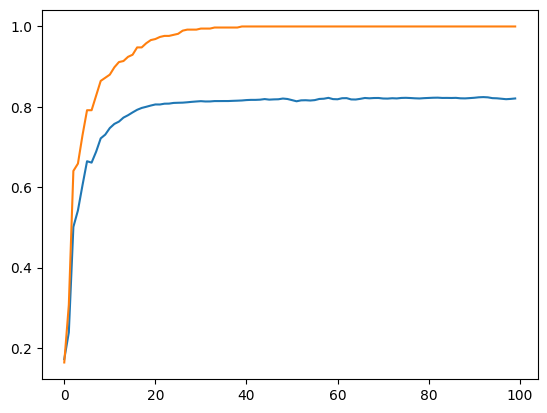

In [6]:
temp = pd.DataFrame()
temp['epcoh'] = epoch_x
temp['train_acc'] = train_acc_list
temp['valid_acc'] = acc_y
temp.to_excel('DNN_Acc_WithOut_Dropout_Epoch{}_Batch{}_Lr{}_Max{}_{}-{}-{}.xlsx'.format(EPOCHS,BATCH_SIZE,LEARN_RATE,max(acc_y),INPUT_SIZE,HIDE_SIZE_I, HIDE_SIZE_O),index = False)
plt.plot(epoch_x,acc_y)
plt.plot(epoch_x,train_acc_list)

In [7]:
class DNN_Dropout(nn.Module):
    def __init__(self,rate):
        super(DNN_Dropout, self).__init__()
        # 隐藏层 1，使用 sigmoid 激活函数
        self.layer1 = nn.Sequential(
            nn.Dropout(p=rate),
            nn.Linear(INPUT_SIZE, HIDE_SIZE_I),
            nn.Sigmoid()
		)
        # 隐藏层 2，使用 sigmoid 激活函数
        self.layer2 = nn.Sequential(
            nn.Linear(HIDE_SIZE_I,HIDE_SIZE_O),
            nn.Sigmoid()
        )
        # 输出层
        self.layer_out = nn.Linear(HIDE_SIZE_O, 10)
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        self.out = self.layer_out(x)
        return self.out

In [8]:
# 实例化DNN，并将模型放在 GPU 训练
dropout_list = []
acc_list = []
for droppout in range(1,10):
    model = DNN_Dropout(droppout/10).to(device)
    # 同样，将损失函数放在 GPU
    loss_fn = nn.MSELoss(reduction='mean').to(device)
    #大数据常用Adam优化器，参数需要model的参数，以及学习率
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
    for epoch in range(EPOCHS):
        # 加载训练数据
        model.train()
        for step, data in enumerate(train_loader):
            if step > 5:
                break
            x, y = data
            """
            因为此时的训练集即 x 大小为 （BATCH_SIZE, 1, 28, 28）
            因此这里需要一个形状转换为（BATCH_SIZE, 784）;

            y 中代表的是每张照片对应的数字，而我们输出的是 10 个神经元，
            即代表每个数字的概率
            因此这里将 y 也转换为该数字对应的 one-hot形式来表示
            """
            x = x.view(x.size(0), 784)
            yy = np.zeros((x.size(0), 10))
            for j in range(x.size(0)):
                yy[j][y[j].item()] = 1
            yy = torch.from_numpy(yy)
            yy = yy.float()
            x, yy = x.to(device), yy.to(device)

            # 调用模型预测
            output = model(x).to(device)
            # 计算损失值
            loss = loss_fn(output, yy)
            # 输出看一下损失变化
    #         print(f'EPOCH({epoch})   loss = {loss.item()}')
            # 每一次循环之前，将梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 梯度下降，更新参数
            optimizer.step()
        sums = 0
        alls = 0
        max_acc = 0
        model.eval()
        for i, data in enumerate(test_loader):
            x, y = data
            # 这里 仅对 x 进行处理
            x = x.view(x.size(0), 784)
            x, y = x.to(device), y.to(device)
            res = model(x).to(device)
            # 得到 模型预测值
            r = torch.argmax(res,dim = 1)
            # 标签，即真实值
            sums += torch.sum(r == y).item()
            alls += r.size()[0]
        if sums / alls > max_acc:
            max_acc = sums / alls
    dropout_list.append(droppout/10)
    acc_list.append(max_acc)
    print('Dropout {} max valid accuracy：'.format(droppout/10),max_acc)

Dropout 0.1 max valid accuracy： 0.8334
Dropout 0.2 max valid accuracy： 0.8346
Dropout 0.3 max valid accuracy： 0.8359
Dropout 0.4 max valid accuracy： 0.8426
Dropout 0.5 max valid accuracy： 0.8386
Dropout 0.6 max valid accuracy： 0.8405
Dropout 0.7 max valid accuracy： 0.8355
Dropout 0.8 max valid accuracy： 0.8286
Dropout 0.9 max valid accuracy： 0.796


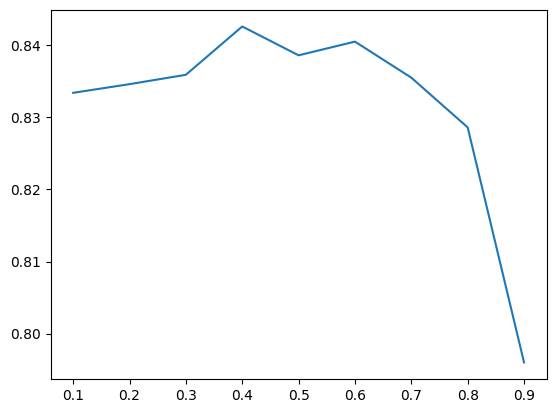

In [10]:
temp = pd.DataFrame()
temp['drop_rate'] = dropout_list
temp['acc'] = acc_list
temp.to_excel('DNN_Acc_Dropout.xlsx'.format(EPOCHS,BATCH_SIZE,LEARN_RATE,max(acc_list),INPUT_SIZE,HIDE_SIZE_I, HIDE_SIZE_O),index = False)
plt.plot(dropout_list,acc_list)

In [12]:
# 实例化DNN，并将模型放在 GPU 训练
best_dropout_rate = temp[temp['acc'] == max(temp['acc'].values)].drop_rate.values[0]
print('Best drop_out rate is ',best_dropout_rate)
model = DNN_Dropout(best_dropout_rate).to(device)
# 同样，将损失函数放在 GPU
loss_fn = nn.MSELoss(reduction='mean').to(device)
#大数据常用Adam优化器，参数需要model的参数，以及学习率
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
epoch_x = []
acc_y = []
train_acc_list = []
for epoch in range(EPOCHS):
    # 加载训练数据
    model.train()
    for step, data in enumerate(train_loader):
        if step > 5:
            break
        x, y = data
        """
        因为此时的训练集即 x 大小为 （BATCH_SIZE, 1, 28, 28）
        因此这里需要一个形状转换为（BATCH_SIZE, 784）;
		
        y 中代表的是每张照片对应的数字，而我们输出的是 10 个神经元，
        即代表每个数字的概率
        因此这里将 y 也转换为该数字对应的 one-hot形式来表示
        """
        x = x.view(x.size(0), 784)
        yy = np.zeros((x.size(0), 10))
        for j in range(x.size(0)):
            yy[j][y[j].item()] = 1
        yy = torch.from_numpy(yy)
        yy = yy.float()
        x, yy = x.to(device), yy.to(device)
 
        # 调用模型预测
        output = model(x).to(device)
        # 计算损失值
        loss = loss_fn(output, yy)
        # 输出看一下损失变化
#         print(f'EPOCH({epoch})   loss = {loss.item()}')
        # 每一次循环之前，将梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 梯度下降，更新参数
        optimizer.step()
    sums = 0
    alls = 0
    model.eval()
    for i, data in enumerate(train_loader):
        if i > 5:
            break
        x, y = data
        # 这里 仅对 x 进行处理
        x = x.view(x.size(0), 784)
        x, y = x.to(device), y.to(device)
        res = model(x).to(device)
        # 得到 模型预测值
        r = torch.argmax(res,dim = 1)
        # 标签，即真实值
        sums += torch.sum(r == y).item()
        alls += r.size()[0]
    train_acc = sums / alls
    sums = 0
    alls = 0
    for i, data in enumerate(test_loader):
        x, y = data
        # 这里 仅对 x 进行处理
        x = x.view(x.size(0), 784)
        x, y = x.to(device), y.to(device)
        res = model(x).to(device)
        # 得到 模型预测值
        r = torch.argmax(res,dim = 1)
        # 标签，即真实值
        sums += torch.sum(r == y).item()
        alls += r.size()[0]
    print('epoch {} train accuracy: {:.4f} valid accuracy：{:.4f}'.format(epoch,train_acc,sums / alls), )
    epoch_x.append(epoch)
    acc_y.append(sums/alls)
    train_acc_list.append(train_acc)
# test：

Best drop_out rate is  0.4
epoch 0 train accuracy: 0.1042 valid accuracy：0.1010
epoch 1 train accuracy: 0.3854 valid accuracy：0.3502
epoch 2 train accuracy: 0.5078 valid accuracy：0.4228
epoch 3 train accuracy: 0.6016 valid accuracy：0.5072
epoch 4 train accuracy: 0.7604 valid accuracy：0.6315
epoch 5 train accuracy: 0.7682 valid accuracy：0.6506
epoch 6 train accuracy: 0.8021 valid accuracy：0.6692
epoch 7 train accuracy: 0.8281 valid accuracy：0.6986
epoch 8 train accuracy: 0.8359 valid accuracy：0.7081
epoch 9 train accuracy: 0.8411 valid accuracy：0.7214
epoch 10 train accuracy: 0.8646 valid accuracy：0.7386
epoch 11 train accuracy: 0.8776 valid accuracy：0.7434
epoch 12 train accuracy: 0.8932 valid accuracy：0.7511
epoch 13 train accuracy: 0.8984 valid accuracy：0.7566
epoch 14 train accuracy: 0.9062 valid accuracy：0.7646
epoch 15 train accuracy: 0.9219 valid accuracy：0.7723
epoch 16 train accuracy: 0.9193 valid accuracy：0.7721
epoch 17 train accuracy: 0.9245 valid accuracy：0.7824
epoch 18 tr

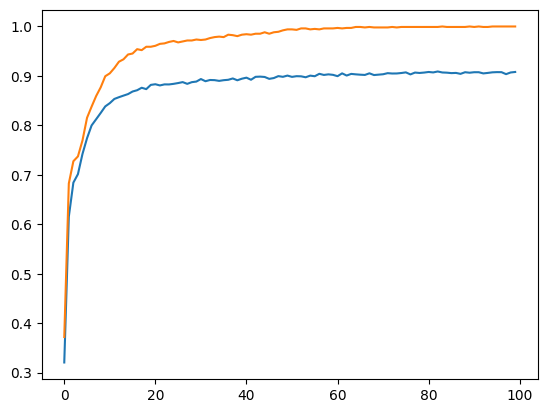

In [30]:
temp = pd.DataFrame()
temp['epcoh'] = epoch_x
temp['train_acc'] = train_acc_list
temp['valid_acc'] = acc_y
temp.to_excel('DNN_Acc_With_Dropout_Epoch{}_Batch{}_Lr{}_Max{}_{}-{}-{}.xlsx'.format(EPOCHS,BATCH_SIZE,LEARN_RATE,max(acc_y),INPUT_SIZE,HIDE_SIZE_I, HIDE_SIZE_O),index = False)
plt.plot(epoch_x,acc_y)
plt.plot(epoch_x,train_acc_list)